In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

from func.propagation import prop2d, defmodel
from func.propagation_tf import simulate_obs
from func.inversion import gradiant
from func.velocity_model import check_model, gaussian2d

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 9
shape of p(z,x,t) = (29, 29, 235)


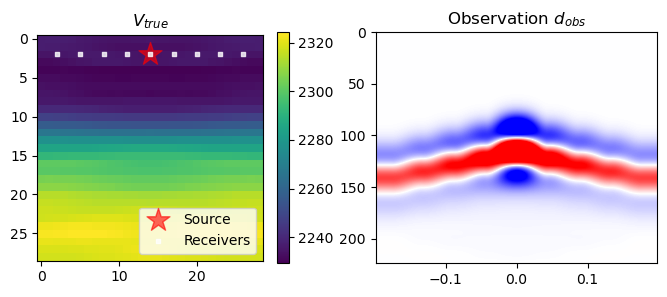

Time per loop: 1.282013230057745 ms
Total time 00h 00m 03s
J = 318.8174133301
gradient shape: (29, 29)


In [105]:
# Import true model and observation
# import pickle
# filename = './data/v_ref'
# infile = open(filename, 'rb')
# v_ref = pickle.load(infile)
# infile.close()

# filename = './data/d_obs'
# infile = open(filename, 'rb')
# d_obs = pickle.load(infile)
# infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [nz//10], [nx//2]
next = 10

v_ref = gaussian2d(ranges=[100,20],variance=50,nx=[nz,nx],param=1,mean=2500)
v_ref = .5* (v_ref + v_ref[:,::-1])

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 3 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
print("Number of receivers:", len(zxrec.flatten())//2)
# Simulate real observation
p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device='cpu')
print("shape of p(z,x,t) =", p.shape)
d_obs = p[zxrec[0], zxrec[1], :]


plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()


v = tf.convert_to_tensor(np.zeros([nz, nx]) + 2500,dtype="float32")
with tf.GradientTape() as tape:
	tape.watch(v)
	start = time.time()
	d = simulate_obs(v, wsrc, zxsrc, at, az, ax, next, zxrec)
	print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))
	# Calculate loss "J"
	loss = .5 * tf.reduce_sum((d - d_obs)**2)
	print("J = %.10f" % loss.numpy())
g = tape.gradient(loss, v)
print("gradient shape:", g.shape)
# plt.figure(figsize=(3,3))
# plt.imshow(g)

Text(0.5, 1.0, 'Comparison')

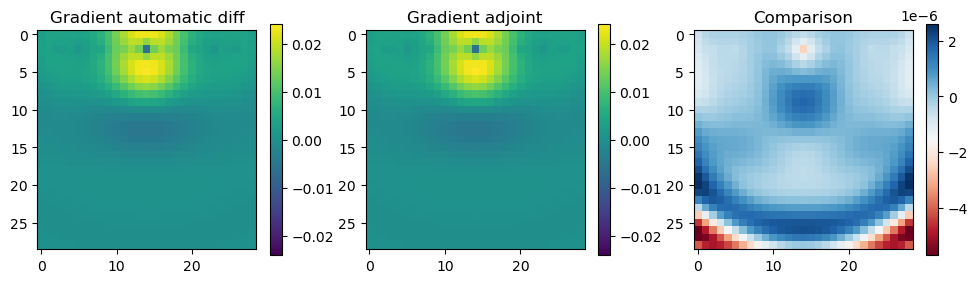

In [108]:
maxi = np.max(abs(g))
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(g,vmin=-maxi,vmax=+maxi)
plt.colorbar()
plt.title("Gradient automatic diff")
plt.subplot(1,3,2)
g_adj = gradiant(v.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device='cpu').reshape(nz,nz)
plt.imshow(g_adj,vmin=-maxi,vmax=+maxi)
plt.colorbar()
plt.title("Gradient adjoint")
plt.subplot(1,3,3)
plt.imshow(g-g_adj,cmap="RdBu")
plt.colorbar()
plt.title("Comparison")

In [23]:
d = simulate_obs(v, wsrc, zxsrc, at, az, ax, next, zxrec)

Time per loop: 1.028124354939604 ms


In [27]:
vel = v
nz,nx,nt = len(az),len(ax),len(at)
vel = tf.convert_to_tensor(vel,dtype="float32")
next = tf.constant(next)
if wsrc.ndim == 1: wsrc=np.array([wsrc]) # convert source wavelet from 1d to 2d
pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[1]] = wsrc	# insert source wavelet
pwsrc = tf.convert_to_tensor(pwsrc,dtype="float32")
# p = prop2d_tf(vel,pwsrc,at,az,ax,next) # propagate

############################ Prop2D ##########################
nabs  = tf.constant(10)
next2 = nabs + next
nt    = tf.size(at)
nz    = tf.size(az)
nx    = tf.size(ax)
az = tf.convert_to_tensor(az,dtype="float32")
ax = tf.convert_to_tensor(ax,dtype="float32")
at = tf.convert_to_tensor(at,dtype="float32")
dz    = az[1] - az[0]
dx    = ax[1] - ax[0]
dt    = at[1] - at[0]   
dz2   = 1./dz**2
dx2   = 1./dx**2
# Extend the model
nze  = nz + 2*next2
nxe  = nx + 2*next2
#########################  EXTEND MODEL ########################
nze  = nz + 2*next2
nxe  = nx + 2*next2
vele = tf.zeros([nze,nxe],dtype="float32")

velnp = tf.convert_to_tensor(vel.numpy())
# Top and bottom
vele = replace(vele,tf.repeat([velnp[0,:]],next2,axis=0),
								[0,next2],[next2,nxe-next2])
vele = replace(vele,tf.repeat([velnp[-1,:]],next2,axis=0),
				[nze-next2,nze],[next2,nxe-next2]) 
# Left and right
vele = replace(vele,tf.transpose(tf.repeat([velnp[:,0]],next2,axis=0)),
					[next2,nze-next2],[0,next2])
vele = replace(vele,tf.transpose(tf.repeat([velnp[:,-1]],next2,axis=0)),
					[next2,nze-next2],[nxe-next2,nxe])
# Corners
vele = replace(vele,tf.fill([next2, next2], velnp[0,0]),
				[0,next2],[0,next2])
vele = replace(vele,tf.fill([next2, next2], velnp[0,-1]),
				[0,next2],[nxe-next2,nxe])
vele = replace(vele,tf.fill([next2, next2], velnp[-1,0]),
				[nze-next2,nze],[0,next2])
vele = replace(vele,tf.fill([next2, next2], velnp[-1,-1]),
				[nze-next2,nze],[nxe-next2,nxe])
# Central part
vele = replace(vele,vel,[next2,nze-next2],[next2,nxe-next2])
###############################################################
# Shift the source by next
p_all = tf.zeros([nze,nxe,2]) # All states wave field
pm = tf.zeros([nze,nxe]) # Previous state wave field
pp = tf.zeros([nze,nxe])# Current state wave field
start = time.time()
for it in tf.range(1,nt-1): # From 1 to nt-1
	fact = (dt*vele[1+nabs:-1-nabs,1+nabs:-1-nabs])**2
	lapx = (pp[1+nabs:-1-nabs,0+nabs:-2-nabs] - \
			2.*pp[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
			pp[1+nabs:-1-nabs,2+nabs:-nabs])*dz2
	lapz = (pp[0+nabs:-2-nabs,1+nabs:-1-nabs] - \
			2.*pp[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
			pp[2+nabs:-nabs,1+nabs:-1-nabs])*dx2
	asrc = tf.zeros([nze-2*nabs-2,nxe-2*nabs-2],dtype="float32")
	asrc = replace(asrc,pwsrc[1:-1,1:-1,it],
					[next,nze-2*nabs-2-next],
				[next,nxe-2*nabs-2-next])
	# One-way equation (center part)
	p0 = 2.*pp[1+nabs:-1-nabs,1+nabs:-1-nabs] - \
			pm[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
			(lapz + lapx + asrc)*fact 
	# One-way equation (bottom part)
	p1 = (pp[nze-1-nabs:nze,:nxe] - \
				vele[nze-1-nabs:nze,:nxe]*dt/dz* \
				(pp[nze-1-nabs:nze,:nxe]-\
				pp[nze-2-nabs:nze-1,:nxe]))[:,1+nabs:nxe-1-nabs]
	# One-way equation (top part)
	p2 = (pp[:1+nabs,:nxe] + \
				vele[:1+nabs,:nxe]*dt/dz* \
				(pp[1:2+nabs,:nxe]-pp[:1+nabs,:nxe]))[:,1+nabs:nxe-1-nabs]
	p012 = tf.concat([p2,p0,p1],axis=0) # top-center-bottom
	# One-way equation (right part)
	p3 = pp[:nze,nxe-1-nabs:nxe] - \
					vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
					(pp[:nze,nxe-1-nabs:nxe] - pp[:nze,nxe-2-nabs:nxe-1])
	# One-way equation (left part)
	p4 = pp[:nze,:1+nabs] + \
					vele[:nze,:1+nabs]*dt/dx* \
					(pp[:nze,1:2+nabs]-pp[:nze,:1+nabs])
	p_next = tf.concat([p4,p012,p3],axis=1) # all parts
	p_all = tf.concat([p_all,tf.expand_dims(p_next,-1)],-1)
	# Update next state and save current state
	pm = pp
	pp = p_next
print("Time per loop:",100*(time.time()-start)/(nt.numpy()-2),"ms")
p =  p_all[next2:nze-next2,next2:nxe-next2,:]

########### Calculate observation at receivers position ##############
nrec = zxrec.shape[1]
d = tf.Variable(tf.zeros([nrec,nt]))
for n in range(nrec):
	d = replace_1d(d,p[zxrec[0,n], zxrec[1,n], :],n,[0,nt])

Time per loop: 1.050594538578148 ms


In [101]:
def simulate_obs(vel, wsrc, zxsrc, at, az, ax, next, zxrec):
	"""
	2d wave propagation with multiple sources
	"""
	nz,nx,nt = len(az),len(ax),len(at)
	vel = tf.convert_to_tensor(vel,dtype="float32")
	next = tf.constant(next)
	if wsrc.ndim == 1: wsrc=np.array([wsrc]) # convert source wavelet from 1d to 2d
	pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
	pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[1]] = wsrc	# insert source wavelet
	pwsrc = tf.convert_to_tensor(pwsrc,dtype="float32")
	# p = prop2d_tf(vel,pwsrc,at,az,ax,next) # propagate

	############################ Prop2D ##########################
	nabs  = tf.constant(10)
	next2 = nabs + next
	nt    = tf.size(at)
	nz    = tf.size(az)
	nx    = tf.size(ax)
	az = tf.convert_to_tensor(az,dtype="float32")
	ax = tf.convert_to_tensor(ax,dtype="float32")
	at = tf.convert_to_tensor(at,dtype="float32")
	dz    = az[1] - az[0]
	dx    = ax[1] - ax[0]
	dt    = at[1] - at[0]   
	dz2   = 1./dz**2
	dx2   = 1./dx**2
	# Extend the model
	nze  = nz + 2*next2
	nxe  = nx + 2*next2
	#########################  EXTEND MODEL ########################
	nze  = nz + 2*next2
	nxe  = nx + 2*next2
	vele = tf.zeros([nze,nxe],dtype="float32")

	velnp = tf.convert_to_tensor(vel.numpy()) # creat velnp to stop recording
	# Top and bottom
	vele = replace(vele,tf.repeat([velnp[0,:]],next2,axis=0),
									[0,next2],[next2,nxe-next2])
	vele = replace(vele,tf.repeat([velnp[-1,:]],next2,axis=0),
					[nze-next2,nze],[next2,nxe-next2]) 
	# Left and right
	vele = replace(vele,tf.transpose(tf.repeat([velnp[:,0]],next2,axis=0)),
						[next2,nze-next2],[0,next2])
	vele = replace(vele,tf.transpose(tf.repeat([velnp[:,-1]],next2,axis=0)),
						[next2,nze-next2],[nxe-next2,nxe])
	# Corners
	vele = replace(vele,tf.fill([next2, next2], velnp[0,0]),
					[0,next2],[0,next2])
	vele = replace(vele,tf.fill([next2, next2], velnp[0,-1]),
					[0,next2],[nxe-next2,nxe])
	vele = replace(vele,tf.fill([next2, next2], velnp[-1,0]),
					[nze-next2,nze],[0,next2])
	vele = replace(vele,tf.fill([next2, next2], velnp[-1,-1]),
					[nze-next2,nze],[nxe-next2,nxe])
	# Central part
	vele = replace(vele,vel,[next2,nze-next2],[next2,nxe-next2])
  	###############################################################
	# Shift the source by next
	p_all = tf.zeros([nze,nxe,2]) # All states wave field
	pm = tf.zeros([nze,nxe]) # Previous state wave field
	pp = tf.zeros([nze,nxe])# Current state wave field
	start = time.time()
	for it in tf.range(1,nt-1): # From 1 to nt-1
		fact = (dt*vele[1+nabs:-1-nabs,1+nabs:-1-nabs])**2
		lapx = (pp[1+nabs:-1-nabs,0+nabs:-2-nabs] - \
				2.*pp[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
				pp[1+nabs:-1-nabs,2+nabs:-nabs])*dz2
		lapz = (pp[0+nabs:-2-nabs,1+nabs:-1-nabs] - \
				2.*pp[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
				pp[2+nabs:-nabs,1+nabs:-1-nabs])*dx2
		asrc = tf.zeros([nze-2*nabs-2,nxe-2*nabs-2],dtype="float32")
		asrc = replace(asrc,pwsrc[1:-1,1:-1,it],
		              [next,nze-2*nabs-2-next],
               		[next,nxe-2*nabs-2-next])
		# One-way equation (center part)
		p0 = 2.*pp[1+nabs:-1-nabs,1+nabs:-1-nabs] - \
				pm[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
				(lapz + lapx + asrc)*fact 
		# One-way equation (bottom part)
		p1 = (pp[nze-1-nabs:nze,:nxe] - \
					vele[nze-1-nabs:nze,:nxe]*dt/dz* \
					(pp[nze-1-nabs:nze,:nxe]-\
					pp[nze-2-nabs:nze-1,:nxe]))[:,1+nabs:nxe-1-nabs]
		# One-way equation (top part)
		p2 = (pp[:1+nabs,:nxe] + \
					vele[:1+nabs,:nxe]*dt/dz* \
					(pp[1:2+nabs,:nxe]-pp[:1+nabs,:nxe]))[:,1+nabs:nxe-1-nabs]
		p012 = tf.concat([p2,p0,p1],axis=0) # top-center-bottom
		# One-way equation (right part)
		p3 = pp[:nze,nxe-1-nabs:nxe] - \
						vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
						(pp[:nze,nxe-1-nabs:nxe] - pp[:nze,nxe-2-nabs:nxe-1])
		# One-way equation (left part)
		p4 = pp[:nze,:1+nabs] + \
						vele[:nze,:1+nabs]*dt/dx* \
						(pp[:nze,1:2+nabs]-pp[:nze,:1+nabs])
		p_next = tf.concat([p4,p012,p3],axis=1) # all parts
		p_all = tf.concat([p_all,tf.expand_dims(p_next,-1)],-1)
		# Update next state and save current state
		pm = pp
		pp = p_next
	print("Time per loop:",100*(time.time()-start)/(nt.numpy()-2),"ms")
	p =  p_all[next2:nze-next2,next2:nxe-next2,:]

	########### Calculate observation at receivers position ##############
	nrec = zxrec.shape[1]
	d = tf.Variable(tf.zeros([nrec,nt]))
	for n in range(nrec):
		d = replace_1d(d,p[zxrec[0,n], zxrec[1,n], :],n,[0,nt])
	return d

# Code to replace tensor elements in tensorflow

def idx_to_replace(z1,z2,x1,x2):
  arr = []
  for i in range(z1,z2):
    for j in range(x1,x2):
      arr.append([i,j])
  return arr

def replace(tensor,arr,iz,ix):
	"""
	tensor: tensor to replace the elements
	arr: the array to insert
	iz,ix: the index of z and x
	"""
	replaced = tf.tensor_scatter_nd_update(
		tensor, 
    idx_to_replace(iz[0],iz[1],ix[0],ix[1]),
    tf.reshape(arr, [-1]))
	return replaced

def idx_to_replace_1d(n,t1,t2):
  arr = []
  for t in range(t1,t2):
      arr.append([n,t])
  return arr

def replace_1d(tensor,arr,n,it):
	"""
	tensor: tensor to replace the elements
	arr: the array to insert
	iz,ix: the index of z and x
	"""
	replaced = tf.tensor_scatter_nd_update(
		tensor, 
    idx_to_replace_1d(n,it[0],it[1]),
    tf.reshape(arr, [-1]))
	return replaced

In [ ]:
from os import P_PID
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import RNN,SimpleRNN
from keras import backend

# First, let's define a RNN Cell, as a layer subclass.
class MinimalRNNCell(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def call(self, inputs, mask):
        pm = mask[0][0,:]
        pp = mask[0][1,:]
        pm = tf.reshape(mask[0][0,:],[68,68])    # previous state
        pp = tf.reshape(mask[0][1,:],[68,68])    # current state
        pws = tf.reshape(mask[0][2,:],[68,68])   # wavelet
        ################################################################
        # print(tf.reduce_sum(pm),tf.reduce_sum(pp))
        fact = (dt*vele[1+nabs:-1-nabs,1+nabs:-1-nabs])**2
        lapx = (pp[1+nabs:-1-nabs,0+nabs:-2-nabs] - \
        2.*pp[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
        pp[1+nabs:-1-nabs,2+nabs:-nabs])*dz2
        lapz = (pp[0+nabs:-2-nabs,1+nabs:-1-nabs] - \
        2.*pp[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
        pp[2+nabs:-nabs,1+nabs:-1-nabs])*dx2
        asrc = tf.zeros([nze-2*nabs-2,nxe-2*nabs-2],dtype="float32")
        asrc = replace(asrc,pws[1:-1,1:-1],
                [next,nze-2*nabs-2-next],
            [next,nxe-2*nabs-2-next])
        print("Check")
        p_next = tf.zeros([nze,nxe])
        p_next = replace(p_next,
                2.*pp[1+nabs:-1-nabs,1+nabs:-1-nabs] - \
                pm[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
                (lapz + lapx + asrc)*fact,
                [1+nabs,nze-1-nabs],[1+nabs,nxe-1-nabs])
        # One-way equation (bottom part)
        p_next = replace(p_next,
            pp[nze-1-nabs:nze,:nxe] - \
            vele[nze-1-nabs:nze,:nxe]*dt/dz* \
            (pp[nze-1-nabs:nze,:nxe]-pp[nze-2-nabs:nze-1,:nxe]),
            [nze-1-nabs,nze],[0,nxe])
        # One-way equation (top part)
        p_next = replace(p_next,
            pp[:1+nabs,:nxe] + \
            vele[:1+nabs,:nxe]*dt/dz* \
            (pp[1:2+nabs,:nxe]-pp[:1+nabs,:nxe]),
            [0,1+nabs],[0,nxe])
        # One-way equation (right part)
        p_next = replace(p_next,pp[:nze,nxe-1-nabs:nxe] - \
            vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
            (pp[:nze,nxe-1-nabs:nxe] - pp[:nze,nxe-2-nabs:nxe-1]),
            [0,nze],[nxe-1-nabs,nxe])
        # One-way equation (left part)
        p_next = replace(p_next,pp[:nze,:1+nabs] + \
            vele[:nze,:1+nabs]*dt/dx* \
            (pp[:nze,1:2+nabs]-pp[:nze,:1+nabs]),
            [0,nze],[0,1+nabs])
        ################################################################
        output = tf.concat([[tf.reshape(pp,[-1])],[tf.reshape(p_next,[-1])],
                            [tf.zeros([1,28*28],)]],0)
        return output, [output]

cell = MinimalRNNCell(68*68)
layer = RNN(cell,return_sequences=True, return_state=True)

state = tf.zeros([2, 235, 68*68],tf.float32)
# pw = tf.reshape(tf.reshape(pwsrc,[28*28,235]),[1,235,28*28])
inputs = tf.concat([state,pw],0)
whole_sequence_output, final_state = layer(inputs)
# print(whole_sequence_output.shape)
whole_sequence_output[0,:,0]


last_state = tf.reshape(whole_sequence_output[-1,:,:],[4624,235])
last_state = tf.reshape(last_state,[68,68,235])[next2:nze-next2,next2:nxe-next2,:]
# Calculate observation at receivers' position
nrec = zxrec.shape[1]
d = tf.zeros([nrec,nt])
for n in range(nrec):
    d = replace_1d(d,p[zxrec[0,n], zxrec[1,n], :],n,[0,nt])
loss = .5 * tf.reduce_sum((d - d_obs)**2)
print("J = %.10f" % loss.numpy())
plt.imshow(d)